In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [10]:
Image_Size = 256
Batch_Size = 32
Channels =3
EPOCHS = 50

In [11]:
 dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    shuffle=True,
    image_size = (Image_Size,Image_Size),
    batch_size = Batch_Size
    
)

Found 2152 files belonging to 3 classes.


In [12]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

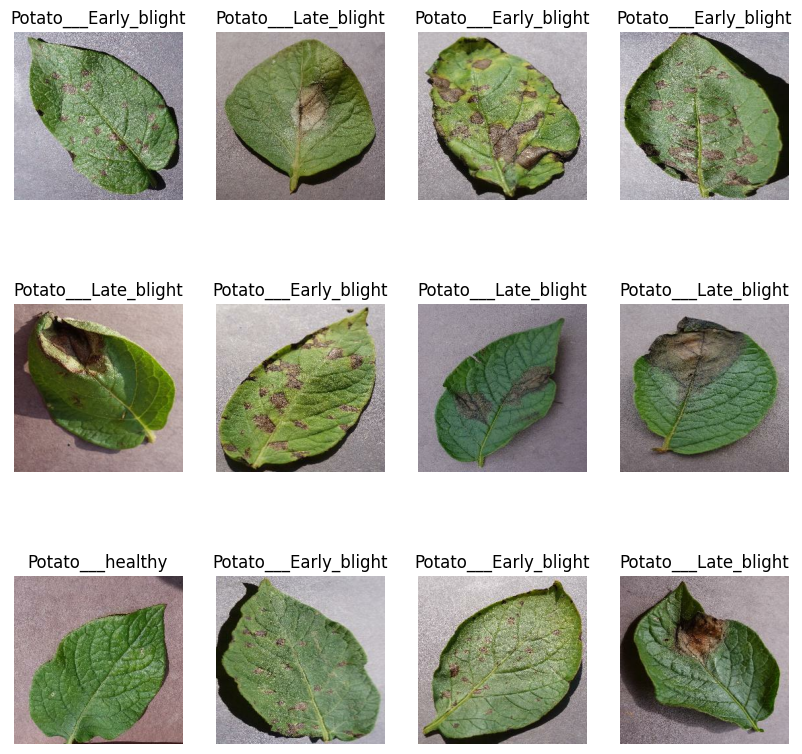

In [13]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        a = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [14]:
len(dataset)

68

Let's use 80% data for Training
10% data - validation
10% data - testing

In [21]:
train_size = 0.8
val_size = 0.1
test_size = 0.1
len(dataset)*train_size


54.400000000000006

In [22]:
len(dataset)*val_size

6.800000000000001

So we can use first 54 batches of dataset to train the data

In [24]:
train_ds = dataset.take(54)
test_ds = dataset.skip(54)
val_ds = test_ds.take(6)
test_ds = test_ds.skip(6)


8

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size,Image_Size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [28]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

Define the Neural Network Architecture 

In [32]:
input_shape = (Batch_Size,Image_Size,Image_Size,Channels)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation="relu", input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(n_classes,activation="softmax")
])

model.build(input_shape = input_shape)

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

Optimize the Model using ADAM

In [37]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics =['accuracy']
)

Training the Model 

In [38]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = Batch_Size,
    verbose = 1,
    validation_data = val_ds
    
)

Epoch 1/50
54/54 [==============================] - 85s 2s/step - loss: 0.9301 - accuracy: 0.4624 - val_loss: 0.8725 - val_accuracy: 0.5469
Epoch 2/50
54/54 [==============================] - 81s 1s/step - loss: 0.8101 - accuracy: 0.6105 - val_loss: 0.8126 - val_accuracy: 0.5260
Epoch 3/50
54/54 [==============================] - 82s 2s/step - loss: 0.5116 - accuracy: 0.7772 - val_loss: 0.4686 - val_accuracy: 0.8125
Epoch 4/50
54/54 [==============================] - 81s 2s/step - loss: 0.3776 - accuracy: 0.8490 - val_loss: 0.3318 - val_accuracy: 0.8698
Epoch 5/50
54/54 [==============================] - 83s 2s/step - loss: 0.3256 - accuracy: 0.8762 - val_loss: 0.3609 - val_accuracy: 0.8646
Epoch 6/50
54/54 [==============================] - 78s 1s/step - loss: 0.2372 - accuracy: 0.9120 - val_loss: 0.2689 - val_accuracy: 0.8906
Epoch 7/50
54/54 [==============================] - 79s 1s/step - loss: 0.1979 - accuracy: 0.9201 - val_loss: 0.5348 - val_accuracy: 0.8021
Epoch 8/50
54/54 [==

In [39]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 162ms/step - loss: 0.1459 - accuracy: 0.9569


In [40]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

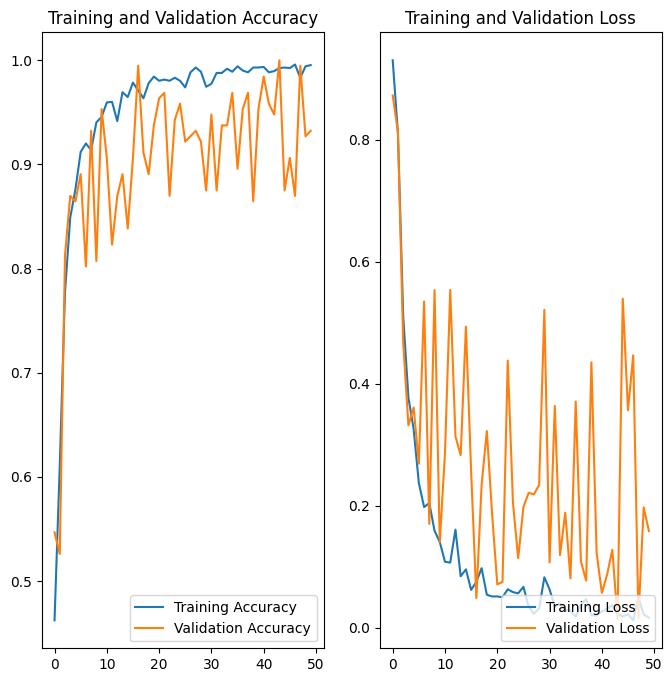

In [43]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label="Training Accuracy")
plt.plot(range(EPOCHS),val_acc,label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label="Training Loss")
plt.plot(range(EPOCHS),val_loss,label="Validation Loss")
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.show()


Image to Predict
Actual label : Potato___Early_blight
1/1 [==============================] - 0s 291ms/step
Predicted Label Potato___Early_blight


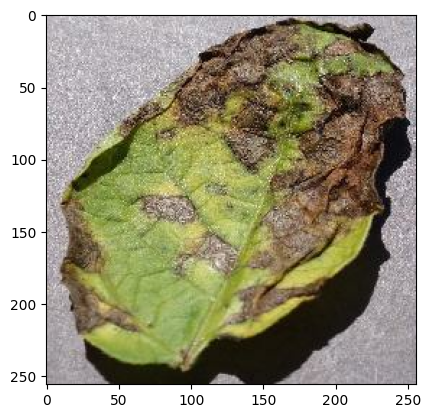

In [105]:
import numpy as np
for image_batch, label_batch in test_ds.take(1):
    
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    print('Image to Predict')
    plt.imshow(first_image)
    print('Actual label :',class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print('Predicted Label',class_names[np.argmax(batch_prediction[0])])